# **Deep Learning Fault Segmentation using Synthetic Seismic Data**

by : leocd91@gmail.com

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1t2AuUy4vj9F5DiZaDKpoCAfXvodq2hxz?usp=sharing">
        <img src="https://i.ibb.co/3723Hm9/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/leocd91/geoscience-ML-tutorial/tree/main">
        <img src="https://i.ibb.co/L5p10GH/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# **Introduction**


---
Welcome to the second episode of "***Geoscience ML Tutorial***" Series.

I made this tutorial as beginner-friendly as possible.
And some code are not *pythonic* for that reason too. Also this is only a straightforward tutorial, I expect you to learn more about approach in Machine learning workflow like feature engineering, data exploration, model evaluation, etc.

Oh yeah, for the deep learning part, We will use Pytorch.

any feedback just hmu.

---

**- Is there any Prereq.?**

> Programming, especially basic python OOP is a must. A basic idea how ML works. Also know how to run line of code in this colab (*hint: just click those 'play' button on the left*)

 **- Who are you giving some tutorials on the internet!?**



> I'm a Petrotechnical Data Management on a NOC in Indonesia. More than 5 years here and still going strong.

> I code my way to finish my undergraduate thesis (FDTD Elastic Wave in cuda) and get some side-gigs from there too (Inversion Method, Numerical Simulation, Etc.).

> I know some C, F95, and Matlab (Now I'm Python *Muallaf* tho).

> My main interest is in computational geophysics and GP-GPU.

> I also *(lazily)* wrote some stuff on my blog about computational geophysics here http://redigitize.blogspot.com/

> I also ***love*** deep-fried banana.



 **TL;DR** I'm not a PhD, CEO, or Someone famous. I'm just glad that I can share something that I learn and learn more from this.

# **Getting ready**

Alright, before we start, let's install some useful package that we will use.

In [85]:
!pip install segyio # for reading segy data
!pip install pytorch_toolbelt # for easy patch-based prediction
!pip install albumentations # for data augmentation
!pip install torchsummary # for pytorch model architecture summary
!pip install onnxscript
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.8 MB/s eta 0:00:00


Then let's first import some package to use in these tutorials

In [6]:
import numpy as np               # well, it's numpy.. powerful array and numerical computation tool (python's matlab)
import matplotlib.pyplot as plt  # well, it's matplotlib.. for data visualization.. plotting
import segyio                    # to easily read segy, but if you got 'abnormal' segy format, I suggest reading it manually (see my other tutorial)
import cv2                       # for image manipulation
import torch                     # pytorch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import albumentations as A                           #for data augmentation
from torch.utils.data import Dataset, DataLoader     #for making a dataset
from sklearn.metrics import f1_score,accuracy_score  #for score metric calculation

let's get training data from https://xeek.ai/challenges/force-seismic/overview

Force Fault Model by Equinor
2020
https://lnkd.in/gHCS2r5



In [7]:
!gdown 'https://drive.google.com/uc?id=1kxe6B2D46x4_Fw9kTZejW14585nTPHUx'

Downloading...
From (original): https://drive.google.com/uc?id=1kxe6B2D46x4_Fw9kTZejW14585nTPHUx
From (redirected): https://drive.google.com/uc?id=1kxe6B2D46x4_Fw9kTZejW14585nTPHUx&confirm=t&uuid=64adc95a-6a1a-48d7-bd6e-282755d6a99a
To: /content/issap20_Pp.sgy
100% 193M/193M [00:04<00:00, 43.7MB/s]


In [8]:
!gdown 'https://drive.google.com/uc?id=1NpSrWq78dNtTvteCOK6gjNZQeFhNwkQ2'

Downloading...
From (original): https://drive.google.com/uc?id=1NpSrWq78dNtTvteCOK6gjNZQeFhNwkQ2
From (redirected): https://drive.google.com/uc?id=1NpSrWq78dNtTvteCOK6gjNZQeFhNwkQ2&confirm=t&uuid=b599b594-9678-4660-bff7-c4baae6bb9f2
To: /content/issap20_Fault.sgy
100% 193M/193M [00:04<00:00, 47.7MB/s]


Now let's read the data just like the notebook from equinor :

In [9]:
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)

data = segy2numpy('issap20_Pp.sgy').transpose(2, 1, 0)
label = segy2numpy('issap20_Fault.sgy').transpose(2, 1, 0)

so, the 3D data is consist of :

In [10]:
print("xline : ", data.shape[1])
print("inline : ", data.shape[2])
print("sample : ", data.shape[0])

xline :  589
inline :  101
sample :  751


let's viz a slice :

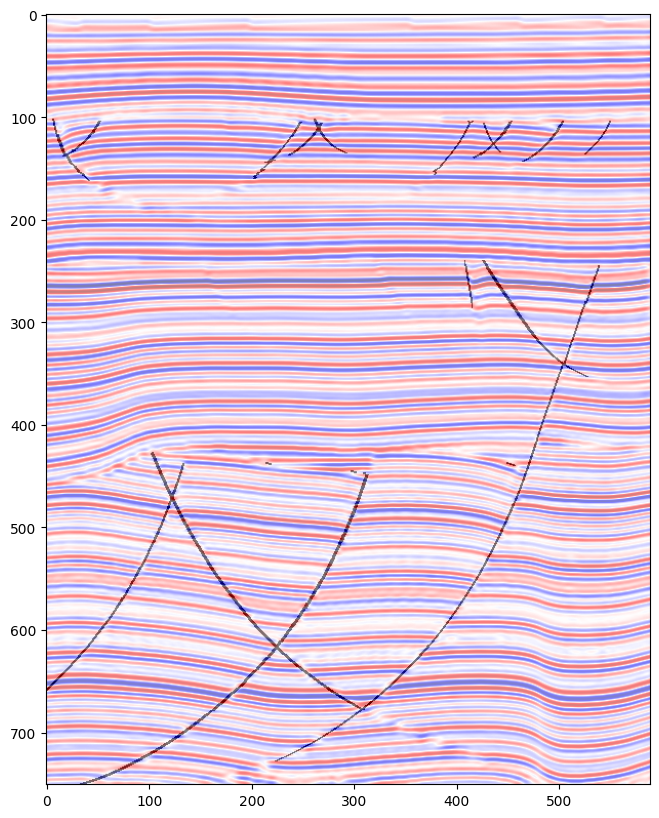

In [11]:
inline=50
fig = plt.figure(figsize=(10,10))
plt.imshow(data[:,:,inline], cmap='seismic')
plt.imshow(label[:,:,inline],cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()

Now let's split the data the first 80 inlines for training and the rest for test.


In [12]:
data_train=data[:,:,:80]
label_train=label[:,:,:80]
data_test=data[:,:,80:]
label_test=label[:,:,80:]

In [13]:
print(data_train.shape)
print(data_test.shape)

(751, 589, 80)
(751, 589, 21)


Why not randomly splitting between inlines?

My suggestion, for data from the same cube seismic, is don't. You'll get the prediction score high because it is easy to predict what between data that is known.

It is better to get test data from different part area of the cube, or even different seismic cube.

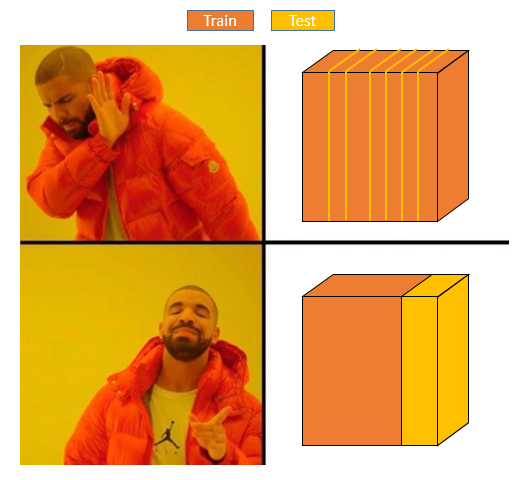

Ok, the next step is making the dataset.

dataset is a class that consist of `__init__`, `__len__` (length of data), `__get__` item (data that we will fetch use).

If you got limited ram, this step is really useful because we can only load it when the batch of data called by reading it from the `__get__` part.

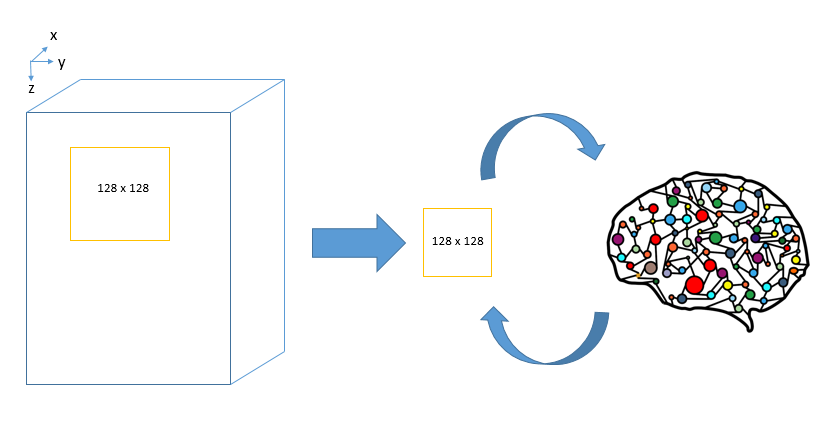

Okay, before we got further, VRAM on GPU is limited.

So either we resize our training data, or we fed it to the model patch by patch (also when predicting).

In this tutorial, we try to make it patch by patch.

So, for the train part, this program below is something like this :
1. Get one slice
2. Do the augmentation by certain probability, so you get 'new' data.
3. Crop it into 128x128

We'll try it like this because we want to use our limited data fully by making a lot of new data from augmentation.

In [14]:
class seisdataset_train(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        self.aug = A.Compose([
            A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0.30, rotate_limit=30) ,
            A.HorizontalFlip(p=0.2),
            A.RandomCrop(p=1, height=128, width=128),
        ])

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        data_aug = self.aug(image=data, mask=label)
        data, label = data_aug['image'], data_aug['mask']
        return data[None,:,:], label

Now let's test our dataset if it is working as expected.

In [15]:
train_data = seisdataset_train(data_train, label_train)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


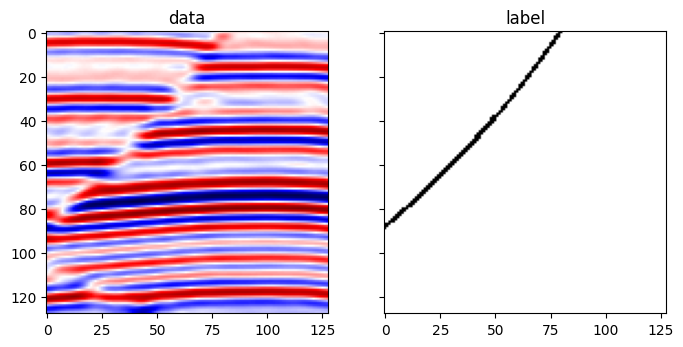

In [16]:
no_sample = 50
data_get = train_data[no_sample]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].imshow(data_get[0][0,:,:], cmap='seismic')
ax[1].imshow(data_get[1], cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
plt.show()

It's working!

Now, For the test part, because it is a test phase, we are going to make it patch by patch.

You can make it into patch by doing it on the dataset class (but it'll be quite a work), or tile the data before using it.

In this tutorial we are going to tile the test set into 128x128 size before.

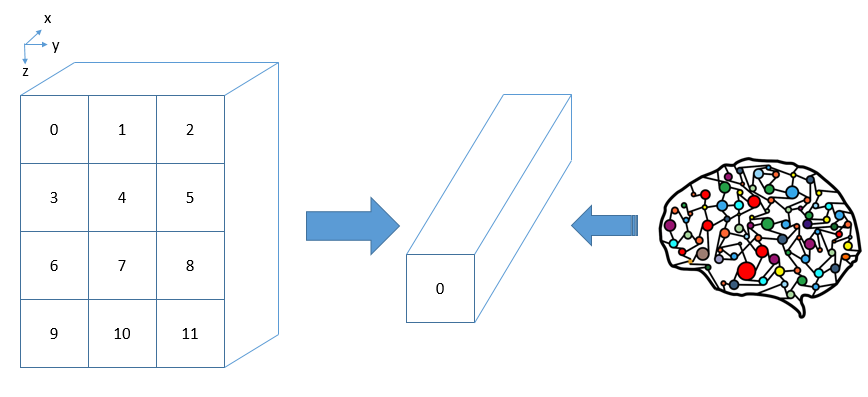

In [17]:
ps = 128 #patch size
lx = int(np.ceil(data_test.shape[0]/ps)*np.ceil(data_test.shape[1]/ps)*data_test.shape[2])
data_test_p = np.zeros([ps,ps,lx],dtype='float32')
label_test_p = np.zeros([ps,ps,lx],dtype='float32')

In [18]:
xx = 0
for x in range(data_test.shape[2]):
  for i in range(int(np.ceil(data_test.shape[0]/ps))):
    for j in range(int(np.ceil(data_test.shape[1]/ps))):
      if i==int(np.ceil(data_test.shape[0]/ps))-1 and j==int(np.ceil(data_test.shape[1]/ps))-1:
        data_test_p[:,:,xx] = data_test[data_test.shape[0]-ps:,data_test.shape[1]-ps:,x]
        label_test_p[:,:,xx] = label_test[data_test.shape[0]-ps:,data_test.shape[1]-ps:,x]
      elif i==int(np.ceil(data_test.shape[0]/ps))-1:
        data_test_p[:,:,xx] = data_test[data_test.shape[0]-ps:,j*ps:j*ps+ps,x]
        label_test_p[:,:,xx] = label_test[data_test.shape[0]-ps:,j*ps:j*ps+ps,x]
      elif j==int(np.ceil(data_test.shape[1]/ps))-1:
        data_test_p[:,:,xx] = data_test[i*ps:i*ps+ps,data_test.shape[1]-ps:,x]
        label_test_p[:,:,xx] = label_test[i*ps:i*ps+ps,data_test.shape[1]-ps:,x]
      else:
        data_test_p[:,:,xx] = data_test[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
        label_test_p[:,:,xx] = label_test[i*ps:i*ps+ps,j*ps:j*ps+ps,x]
      xx=xx+1
data_test_p.shape

(128, 128, 630)

Now let's check if the tiling data is right.

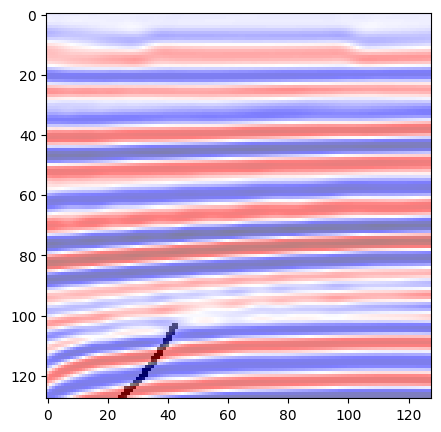

In [19]:
inline=30
fig = plt.figure(figsize=(5,5))
plt.imshow(data_test_p[:,:,inline], cmap='seismic')
plt.imshow(label_test_p[:,:,inline],cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()

Great, because we already tiled the data, the test dataset class will be pretty simple.

In [20]:
class seisdataset_test(Dataset):
    def __init__(self, X, y, training=True):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        return data[None,:,:], label

---

After the data handling part ready, Now..

Let's put some parameters for our training..

In [21]:
batch_size = 8        #
num_epochs = 150      # its how many times the model learning from all data being fed
num_classes = 2       # its a binary classification, fault/no fault, so its 2.
learning_rate = 0.001 # pretty common things on optimization/inversion problems (especially those who know geophysics)
                      # larger learning rate means faster to converge but you won't find the global optimum and opposite

`shuffle` is for shuffling the dataset, and `drop_last` is for dropping the last dataset that is not evenly divisible by batch size.

In [22]:
def get_data_loaders(batch_size):
    train_data = seisdataset_train(data_train, label_train)
    test_data = seisdataset_test(data_test_p, label_test_p)

    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader,test_loader=get_data_loaders(batch_size)

Now, the model architecture that we will use is the famous Unet with little bit of modification.

You can read more about Unet [here](https://arxiv.org/abs/1505.04597) and [here](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)

Basically the network is like this :

<img src="https://miro.medium.com/max/700/1*OkUrpDD6I0FpugA_bbYBJQ.png"  height="600px" style="padding-bottom:5px;"  />



In [24]:
#https://github.com/milesial/Pytorch-UNet/

import torch.nn.functional as F
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

After defining the architecture model, now let's put it into the GPU.

Then choose the [loss function](https://en.wikipedia.org/wiki/Loss_function) and [optimizer](https://en.wikipedia.org/wiki/Mathematical_optimization) that we will use (`Adam` with default hyperparameter).

In [25]:
model = UNet(n_channels=1, n_classes=num_classes).to(device)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Using `torchsummary`, we can see the model summary and it's size so we can plan the batch size and such.

In [26]:
from torchsummary import summary
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

let's test it with random input to see if there is any error.

In [27]:
test = torch.rand(1, 1, 128, 128).cuda()
out = model(test)
out.shape

torch.Size([1, 2, 128, 128])

as you can see, the output 2nd shape size is the number of class that we try to segment.

If it's a 3 class or more, like for example facies classification problem, then it will be 3, etc.

to make it into 2D mask which shows fault / no fault, just find the max indices


In [28]:
lbl_pred = out.data.max(1)[1].cpu().numpy()[:, :, :] #.cpu() because we are currently using the gpu
lbl_pred[0,:,:].shape

(128, 128)

or some people just `softmax` it then choose their own constraint.

Okay, nothing wrong with the architecture, then next is..

# **Training**

let's get into training part.

Put some empty variable to put our train-test score for future model evaluation.

In [29]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
train_acc = []
test_acc = []

Then train it.

The program  below basically just :
1. train the dataset,
2. calculate train loss and score,
3. backward to update the network weights (In geophysics usually called this by 'inversion' part),
4. testing the data set,
5. calculate and updating the test score,
6. repeat till last epoch.

It's gonna take some time so let's watch some youtube's videos.

See you in ten minute-ish!

In [30]:
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    acc_test = 0.0
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        #print(label.shape)
        #print(pred.shape)
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc

    model.eval()
    for data, label in test_loader:

        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)

        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        acc_test += acc


    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    # print
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tF1_train: {:.6f} \tF1_test: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test))

Epoch: 1 	Training Loss: 0.311056 	Validation Loss: 3.049382 	F1_train: 0.004807 	F1_test: 0.000000
Epoch: 2 	Training Loss: 0.176551 	Validation Loss: 1.322325 	F1_train: 0.000000 	F1_test: 0.000000
Epoch: 3 	Training Loss: 0.127629 	Validation Loss: 0.925016 	F1_train: 0.000000 	F1_test: 0.000000
Epoch: 4 	Training Loss: 0.104506 	Validation Loss: 0.787143 	F1_train: 0.000000 	F1_test: 0.000000
Epoch: 5 	Training Loss: 0.083431 	Validation Loss: 0.656440 	F1_train: 0.000000 	F1_test: 0.000000
Epoch: 6 	Training Loss: 0.087326 	Validation Loss: 0.682736 	F1_train: 0.002383 	F1_test: 0.000145
Epoch: 7 	Training Loss: 0.070845 	Validation Loss: 0.660105 	F1_train: 0.002635 	F1_test: 0.000609
Epoch: 8 	Training Loss: 0.079778 	Validation Loss: 0.525672 	F1_train: 0.016669 	F1_test: 0.002650
Epoch: 9 	Training Loss: 0.066476 	Validation Loss: 0.482864 	F1_train: 0.003854 	F1_test: 0.000156
Epoch: 10 	Training Loss: 0.063205 	Validation Loss: 0.469968 	F1_train: 0.005945 	F1_test: 0.000058

---

You can save the model checkpoint for future use or retrain again by using this command :

In [ ]:
torch.save(model.state_dict(), 'model'+str(epoch)+'.ckpt')

..and let's check the model performance from our training

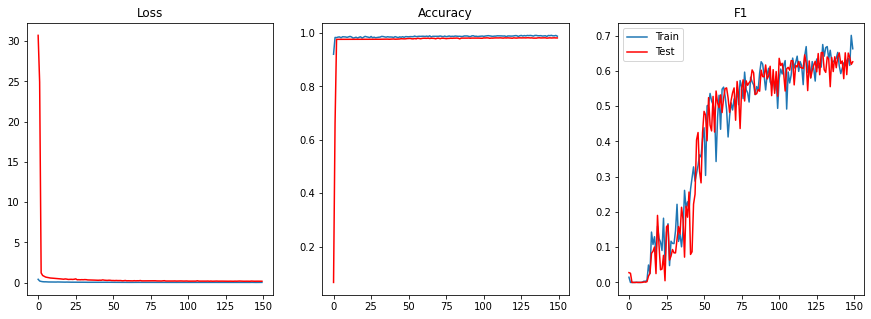

In [ ]:
fig2, ax = plt.subplots(1,3,  figsize=(15,5))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[2].plot(train_F1)
ax[0].plot(valid_losses,'-r')
ax[1].plot(test_acc,'-r')
ax[2].plot(test_F1,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('F1')
ax[2].legend(("Train", "Test"))
plt.show()

In [40]:
data_test[200:328,150:278,10].shape

(128, 128)

## Before you start

Install those additional packages:
```
onnxscript
onnxruntime
```

## Get the device

```
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```

## Let's first generate a dummy input

```
dummy_input = torch.randn(1, 1, 128, 128, requires_grad=True)
```

## Let's test model inference with the dummy input

```
input_model = dummy_input.clone().to(device)
output = model(dummy_input)
```

## Now let's convert the file to onnx

```
# set the model to inference mode
model.eval()

# Export the model   
torch.onnx.export(
  model,         # model being run
  dummy_input,   # model input
  "model.onnx",  # where to save the model  
  dynamo=True
  )
```

## Reload the onnx and run inference

```
import onnxruntime as ort

ort_session = ort.InferenceSession("model.onnx")

input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

output_onnx = ort_session.run([output_name], {input_name: dummy_input})
```

## Finally, compare both outputs

```
output
output_onnx
```

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [65]:
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [75]:
dummy_input = torch.randn(1, 1, 128, 128, requires_grad=True).to(device)

In [76]:
dummy_input.shape

torch.Size([1, 1, 128, 128])

In [77]:
print(dummy_input.device)

cuda:0


In [78]:
# test inference with dummy input to confirm input shape
output=model(dummy_input)

In [79]:
output

tensor([[[[ 4.7484,  4.3056,  4.8860,  ...,  6.0811,  5.3493,  5.1524],
          [ 4.7337,  4.6068,  4.7418,  ...,  7.6839,  6.2135,  5.6823],
          [ 5.4047,  5.1970,  5.9009,  ...,  8.2093,  7.6490,  5.6731],
          ...,
          [ 4.9304,  6.5718,  7.1090,  ...,  7.4854,  6.2087,  5.2003],
          [ 4.5902,  5.4298,  5.4893,  ...,  6.0225,  5.0662,  4.5438],
          [ 4.5853,  4.6792,  5.3675,  ...,  4.5724,  4.4101,  4.1061]],

         [[-4.4184, -4.4187, -4.4424,  ..., -5.0226, -4.4812, -3.8276],
          [-5.4569, -5.3548, -5.4535,  ..., -8.0447, -5.7845, -5.1988],
          [-5.9482, -5.9627, -6.5691,  ..., -8.1127, -7.4027, -4.3752],
          ...,
          [-6.0504, -8.0987, -8.4552,  ..., -8.8345, -6.0455, -4.5329],
          [-5.2043, -6.0625, -6.7585,  ..., -6.4614, -5.4585, -3.9865],
          [-4.9378, -5.6608, -5.8448,  ..., -5.0737, -4.6229, -3.3533]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [80]:
# set the model to inference mode
model.eval()

# Export the model
torch.onnx.export(model,         # model being run
      dummy_input,       # model input (or a tuple for multiple inputs)
      "model.onnx",       # where to save the model
      dynamo=True)

[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 18 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.8.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"x"<FLOAT,[1,1,128,128]>
            ),
            outputs=(
                %"conv2d_18"<FLOAT,[1,2,128,128]>
            ),
            initializers=(
                %"inc.double_conv.0.weight"<FLOAT,[64,1,3,3]>{Tensor(...)},
                %"inc.double_conv.0.bias"<FLOAT,[64]>{Tensor(...)},
                %"inc.double_conv.3.weight"<FLOAT,[64,64,3,3]>{Tensor(...)},
                %"inc.double_conv.3.bias"<FLOAT,[64]>{Tensor(...)},
                %"down1.maxpool_conv.1.double_conv.0.weight"<FLOAT,[128,64,3,3]>{Tensor(...)},
                %"down1.maxpool_conv.1.double_conv.0.bias"<FLOAT,[128]>{Tensor(...)},
                %"down1.maxpool_conv.1.double_con

In [86]:
import onnx
import onnxruntime as ort

In [82]:
onnx_model = onnx.load("model.onnx")

In [83]:
onnx.checker.check_model(onnx_model)

In [87]:
ort_session = ort.InferenceSession("model.onnx")

In [89]:
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

In [94]:
dummy_input = torch.randn(1, 1, 128, 128).numpy()
dummy_input

array([[[[-0.23103894, -1.043573  , -1.1173967 , ..., -0.72080547,
           0.8373931 ,  1.0592928 ],
         [ 0.11817106, -0.01535438,  1.0932559 , ..., -1.5282255 ,
           0.6027567 ,  0.7591625 ],
         [-0.33918142,  0.13423358,  1.004732  , ...,  1.2423184 ,
           0.577894  ,  1.3586997 ],
         ...,
         [ 0.23932597, -0.43714178, -0.03193477, ...,  2.7482595 ,
          -1.058416  ,  2.28675   ],
         [ 1.366369  ,  0.01843867, -0.5041526 , ...,  1.5787183 ,
          -0.9718891 , -0.3391077 ],
         [ 0.4193319 , -0.10992517, -1.3949461 , ..., -0.7461014 ,
          -0.33334053,  2.3217218 ]]]], dtype=float32)

In [95]:
ort_session.run([output_name], {input_name: dummy_input})

[array([[[[ 4.671723 ,  4.53762  ,  5.6787043, ...,  5.795254 ,
            6.424547 ,  6.053516 ],
          [ 4.9483366,  4.8863573,  5.47262  , ...,  8.826369 ,
            7.267245 ,  6.966958 ],
          [ 5.262914 ,  4.783247 ,  7.2344747, ...,  8.326452 ,
            8.681706 ,  7.537461 ],
          ...,
          [ 4.7434926,  5.4730573,  6.6227603, ...,  8.2216625,
            7.496739 ,  6.0989532],
          [ 4.3921547,  4.598681 ,  5.045378 , ...,  7.1530824,
            6.0500226,  5.447628 ],
          [ 4.245633 ,  4.7220306,  4.906138 , ...,  5.7355824,
            4.9529195,  4.287946 ]],
 
         [[-4.3567   , -4.764541 , -5.1182604, ..., -5.1130824,
           -4.942786 , -4.1981206],
          [-5.9022202, -5.89361  , -6.276587 , ..., -8.962946 ,
           -6.843042 , -6.019571 ],
          [-5.9149613, -6.236452 , -8.262322 , ..., -9.059254 ,
           -8.292235 , -5.7476964],
          ...,
          [-5.5509367, -6.9524064, -7.5142307, ..., -9.752462 ,
   

# **Predicting**

---

Now let's test our model prediction :

In [ ]:
inline=10 #inline from test set

slice_test1 = data_test[200:328,150:278,inline]
label_true = label_test[200:328,150:278,inline]

In [ ]:
input_data = torch.from_numpy(slice_test1[None, None, : , :]).float()
output=model(input_data.cuda())
preds=output.data.max(1)[1].cpu().numpy()[0, :, :]

Now some visualization for the result..

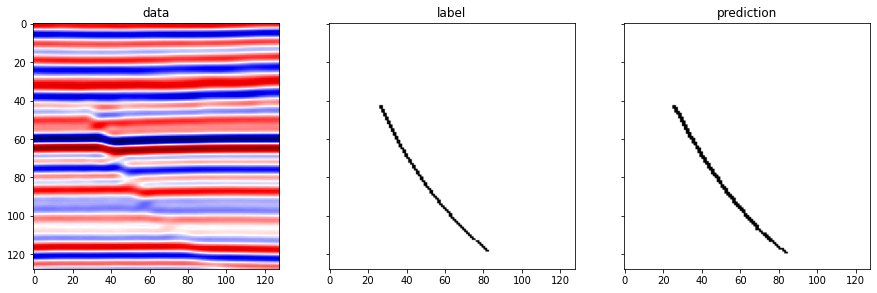

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,15))
ax[0].imshow(slice_test1, cmap='seismic')
ax[1].imshow(label_true, cmap='Greys')
ax[2].imshow(preds, cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
ax[2].set_title('prediction')

plt.show()

As you can see, the model can predict the fault.

---

Let's try to predict one slice patch by patch then!

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import cv2

from pytorch_toolbelt.inference.tiles import ImageSlicer, CudaTileMerger
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy


img = data_test[:,:,inline]
model.eval()

tiler = ImageSlicer(img.shape, tile_size=(128, 128), tile_step=(64, 64))
merger = CudaTileMerger(tiler.target_shape, 1, tiler.weight)

tiles = [tile for tile in tiler.split(img[:, :, None])]

for tiles_batch, coords_batch in DataLoader(list(zip(tiles, tiler.crops)), batch_size=1):
    tiles_batch = tiles_batch.permute(0, 3, 1, 2)
    output=model(tiles_batch.to(device))
    pred_batch=output.data.max(1)[1]
    merger.integrate_batch(pred_batch, coords_batch)
merged_mask = np.moveaxis(to_numpy(merger.merge()), 0, -1).astype(np.uint8)
merged_mask = tiler.crop_to_orignal_size(merged_mask)
merged_mask=merged_mask[:,:,0]

---

Now, let's see our result.

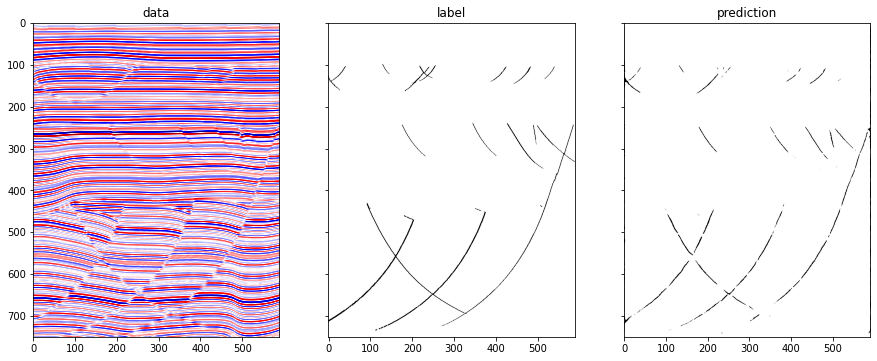

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,15))
ax[0].imshow(data_test[:,:,inline], cmap='seismic')
ax[1].imshow(label_test[:,:,inline], cmap='Greys')
ax[2].imshow(merged_mask, cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
ax[2].set_title('prediction')

plt.show()

Not bad! :)

See you again on the next part where we will to try to predict on real data.

# **Exercises**

1. Try to add more augmentations! You can also do precondition the data or add noise. (hint: filter, seismic attributes, elastic deformation)
2. Try using another model architecture! there are other famous model like **PSPnet** and **Deeplab** that you can use!
3. Try adding another layer for feature map extraction before using the unet! (FC, ResNet, etc)
4. Modify the code so it'll save the model at it's best score!
